<a name="top"></a><img src="source/SpinalHDL.png" alt="SpinalHDL based on Scala" style="width:320px;" />

Before running Spinal HDL code, be sure to load SpinalHDL Libraries  
**Note** : This may be a little slow when the first time load, please wait a moment to download Lib from remote.)   

In [2]:
System.setProperty("https.proxyHost", "192.168.67.2")
System.setProperty("https.proxyPort", "3128")
val path = System.getProperty("user.dir") + "/source/load-spinal.sc"
interp.load.module(ammonite.ops.Path(java.nio.file.FileSystems.getDefault().getPath(path)))

Downloaded https://repo1.maven.org/maven2/com/github/spinalhdl/spinalhdl-core_2.12/1.4.1/spinalhdl-core_2.12-1.4.1.pom
Downloaded https://repo1.maven.org/maven2/com/github/spinalhdl/spinalhdl-sim_2.12/1.4.1/spinalhdl-sim_2.12-1.4.1.pom
Downloaded https://repo1.maven.org/maven2/com/github/spinalhdl/spinalhdl-idsl-plugin_2.12/1.4.1/spinalhdl-idsl-plugin_2.12-1.4.1.pom
Downloaded https://repo1.maven.org/maven2/commons-io/commons-io/2.4/commons-io-2.4.pom
Downloaded https://repo1.maven.org/maven2/net/openhft/affinity/3.1.11/affinity-3.1.11.pom
Downloaded https://repo1.maven.org/maven2/org/slf4j/slf4j-simple/1.7.25/slf4j-simple-1.7.25.pom
Downloaded https://repo1.maven.org/maven2/com/github/dblock/oshi-core/3.4.0/oshi-core-3.4.0.pom
Downloaded https://repo1.maven.org/maven2/com/github/spinalhdl/spinalhdl-idsl-payload_2.12/1.4.1/spinalhdl-idsl-payload_2.12-1.4.1.pom
Downloaded https://repo1.maven.org/maven2/com/github/dblock/oshi-parent/3.4.0/oshi-parent-3.4.0.pom
Downloaded https://repo1.ma

Compiling /workspaces/myenv/Spinal-bootcamp/Main.sc

res1_0: String = null
res1_1: String = null
path: String = "/workspaces/myenv/Spinal-bootcamp/source/load-spinal.sc"

**Note2**: Sometimes we use *"Spinal"* as *"SpinalHDL"* for short, all *"spinal"*,*"Spinal"* appeared means SpinalHDL

## What is this 
This is SpinalHDL Tutorial, More important, it's a spinalHDL run-time environment.

Most of case come from [SpinalDoc](https://spinalhdl.github.io/SpinalDoc-RTD/index.html),
In addition, we also introduced some advanced uses of Scala, which are very helpful to use SpinalHDL and understand how spinalHDL works.

**Why we do such a thing:**
- Sometimes you just want to try a usage of a Spinal or Scala, but you don't want to create a new project.
- Practice is Important for learning a new skill. So we did a lot of examples for you to try run.
 
**Before the start**  

  We assume you already have the basics knowledge of Scala，So there is no introduction to scala syntax here.  
If you need to learn Scala, I would strongly recommend the book of "Programming in Scala"by Martin Odersky who is also the author of Scala 

## Two useful  function

If you want show the generated RTL code in Jupyter-Notebook, use this：

- **`showRtl(new MyTop)`** show RTL code, default Verilog，
- **`showRtl(new MyTop,VHDL)`** show VHDL code，more simple way **`showVhdl(new myTop)`**

SpinalHDL defualt RTL generate methods:

- **`SpinalVerilog(new MyTop)`** generate Verilog under current dir
- **`SpinalVhdl(new MyTop)`** generate VHDL under current dir

Specific dir:  
**`SpinalConfig(mode = Verilog, targetDirectory="rtl/").generate(new MyTop)`**

## First Simple Adder Module
 
A simple adder with parameterized width, the result width auto propogated by Spinal.

Click Run to see what happen!

In [ ]:
class Adder(width: Int) extends Component{
  val a = in(UInt(width bits))
  val b = in(UInt(width bits))
  val c = out(UInt()) 
  c := a + b
}
showRtl(new Adder(8))

The keyword of `Component` comes from VHDL. But for Verilog users, `Moudle` may be more familiar.    
If you like, just use **`type Module = Component`**, it's totally okay.

In [ ]:
type Module = Component 

class Adder(width: Int) extends Module{
  val a = in(UInt(width bits))
  val b = in(UInt(width bits))
  val c = out(UInt()) 
  c := a + b
}
showRtl(new Adder(8))

## How to generate a Soc Top
 
It's a very simple thing in spinal. It may take 2 second, use one line of Spinal code   `SpinalVerilog(new Pinsec(500 MHz))`

In [ ]:
import spinal.lib.soc.pinsec._
SpinalVerilog(new Pinsec(500 MHz))

This will generate a complete SOC of **Pinsec.v** under current dir, you can also use `showRtl(new Pinsec(500 MHz)` show them on the current page.

Which contains a riscv processor, a set of Axi cross bars, and MEM, JTAG, APB bridge, timer, GPIO and other peripherals.
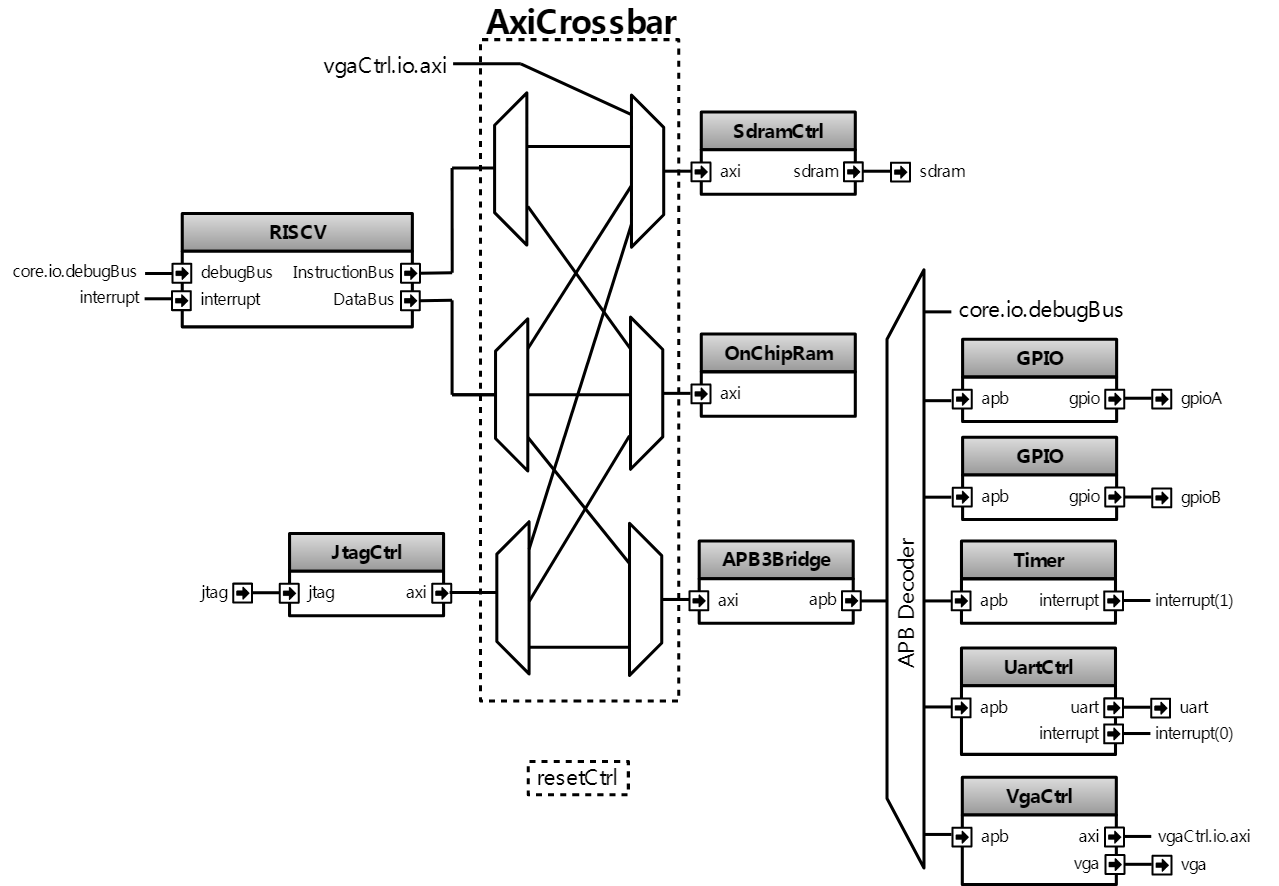

You may have some questions. What does it generate in such a simple way?  
Can I customize the parameter specifications by myself? There is no problem at all.

Please execute the following code snippets in order to customize the SOC

### First Config Cpu


In [ ]:
import spinal.lib.bus.amba3.apb._
import spinal.lib.bus.amba4.axi._
import spinal.lib.com.jtag.Jtag
import spinal.lib.com.uart.{Uart, UartCtrlGenerics, UartCtrlMemoryMappedConfig, Apb3UartCtrl}
import spinal.lib.cpu.riscv.impl.Utils.BR
import spinal.lib.cpu.riscv.impl.build.RiscvAxi4
import spinal.lib.cpu.riscv.impl.extension.{BarrelShifterFullExtension, DivExtension, MulExtension}
import spinal.lib.cpu.riscv.impl._
import spinal.lib.graphic.RgbConfig
import spinal.lib.graphic.vga.{Vga, Axi4VgaCtrlGenerics, Axi4VgaCtrl}
import spinal.lib.io.TriStateArray
import spinal.lib.memory.sdram._
import spinal.lib.system.debugger.{JtagAxi4SharedDebugger, SystemDebuggerConfig}

val myCpuConfig = RiscvCoreConfig(
        pcWidth = 32,
        addrWidth = 32,
        startAddress = 0x00000000,
        regFileReadyKind = sync,
        branchPrediction = dynamic,
        bypassExecute0 = true,
        bypassExecute1 = true,
        bypassWriteBack = true,
        bypassWriteBackBuffer = true,
        collapseBubble = false,
        fastFetchCmdPcCalculation = true,
        dynamicBranchPredictorCacheSizeLog2 = 7
      )

myCpuConfig.add(new MulExtension)
myCpuConfig.add(new DivExtension)
myCpuConfig.add(new BarrelShifterFullExtension)

### Extension your CPU
```scala
myCpuConfig.add(new MulExtension)
myCpuConfig.add(new DivExtension)
myCpuConfig.add(new BarrelShifterFullExtension)
```

If you've developed floating-core or vector processing extensions with Spinal, you can also extension it this way

```scala
myCpuConfig.add(new myFloatExtension)
myCpuConfig.add(new myVectorExtension) 
```

### Config your iCache

In [ ]:
val myiCacheConfig = InstructionCacheConfig(
        cacheSize    = 4096,
        bytePerLine  = 32,
        wayCount     = 1,  //Can only be one for the moment
        wrappedMemAccess = true,
        addressWidth = 32,
        cpuDataWidth = 32,
        memDataWidth = 32
      )

###  ReConfig your Soc

Put the new riscvCpu，iCache config into Soc config，We can get a completely new **Configed Soc System**

In [ ]:
import spinal.lib.memory.sdram.sdr.IS42x320D
val mySocConfig = PinsecConfig(
    axiFrequency   = 100 MHz,
    onChipRamSize  = 4 KiB,
    sdramLayout    = IS42x320D.layout,
    sdramTimings   = IS42x320D.timingGrade7,
    cpu            = myCpuConfig,
    iCache         = myiCacheConfig)

showRtl(new Pinsec(mySocConfig))

## Spinal Global Config
we can config Global setting in SpinalConfig, such like Asynchronous reset with falling age, or generated-dir etc.

In [ ]:
object MySpinalConfig extends SpinalConfig(
    defaultConfigForClockDomains = ClockDomainConfig(
                                         resetKind = ASYNC,
                                         clockEdge = RISING, 
                                         resetActiveLevel = LOW)
)
MySpinalConfig.generateVerilog(new Pinsec(500 MHz))

## Some interesting concepts
The author of spinalhdl gives us all interesting designs, such as clock frequency, time unit, storage space, etc., which are very simple but very useful.

It may provide more expressiveness and abstraction in parametric design.

In [ ]:
val freq = 100 MHz
val time = 10 ms
//val time = 100 $ 100.$() =  return  RBM(100)
val cycle = time * freq 

## Useful Utlis and Lib
- Flow
- Stream
- IMasterSlave
- Fragment
- Bus 
  + AHB-lite3
  + AXI4
  + APB3
  + AvalonMM
- URT
- VGA

## A complete SOC framework
Pinsec is a complete SOC project with a very clear structure, and powerful.  

To coin a phrase: The house sparrow is small,but be fullies equipped 

## More details  
- [SpinalDocument](https://spinalhdl.github.io/SpinalDoc-RTD/index.html)
